## 第10章 アンケート分析を行うための自然言語処理10本ノック

この記事は[「Python実践データ分析100本ノック」](https://www.amazon.co.jp/dp/B07ZSGSN9S/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)の演習を実際にやってみたという内容になっています。今まで自己流でやってきましたが、一度他の方々がどのような考え方やコーディングをしているのか勉強してみようと思ってやってみました。本書は実際の業務に活用する上でとても参考になる内容だと思っています。データ分析に関わる仕事をしたい方にお勧めしたいです。

アンケート処理の演習になります。こちらも前の章よりはやりやすかったです。しかしとても勉強になるので、ぜひとも自分のものにしたいです。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/ml/data100/10/10_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/ml/data100/10/10_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G95


In [2]:
!python -V

Python 3.5.5 :: Anaconda, Inc.


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)

matplotlib version : 2.2.2
scipy version : 1.4.1
numpy version : 1.18.1
pandas version : 0.24.2


## 解答

### ノック 91 : データを読み込んで把握しよう

In [4]:
survey = pd.read_csv('survey.csv')
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(AA駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [5]:
len(survey)

86

In [6]:
survey.isna().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

実際のデータではユーザーがコメントしてくれない場合は多分にあります。

In [7]:
survey = survey.dropna()
survey.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

In [8]:
len(survey)

84

### ノック 92 : 不要な文字を除去してみよう

In [9]:
survey['comment'] = survey['comment'].str.replace('AA', '')
survey['comment'].head()

0     駅前に若者が集まっている(駅)
1    スポーツできる場所があるのが良い
2           子育て支援が嬉しい
3     保育園に入れる（待機児童なし）
4           駅前商店街が寂しい
Name: comment, dtype: object

正規表現で括弧付きのパターンを削除します。

In [10]:
survey['comment'] = survey['comment'].str.replace("\(.+?\)", "" ,regex=True)
survey['comment'].head()

0        駅前に若者が集まっている
1    スポーツできる場所があるのが良い
2           子育て支援が嬉しい
3     保育園に入れる（待機児童なし）
4           駅前商店街が寂しい
Name: comment, dtype: object

大文字の括弧も削除の対象にします。

In [11]:
survey['comment'] = survey['comment'].str.replace("\（.+?\）", "" ,regex=True)
survey['comment'].head()

0        駅前に若者が集まっている
1    スポーツできる場所があるのが良い
2           子育て支援が嬉しい
3             保育園に入れる
4           駅前商店街が寂しい
Name: comment, dtype: object

### ノック 93 : 文字列をカウントしてヒストグラムを表示してみよう

In [12]:
survey['length'] = survey['comment'].str.len()
survey.head()

,datetime,comment,satisfaction,length
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる,4,7
4,2019/1/6,駅前商店街が寂しい,2,9


分布を見たいのでヒストグラム表示してみます。

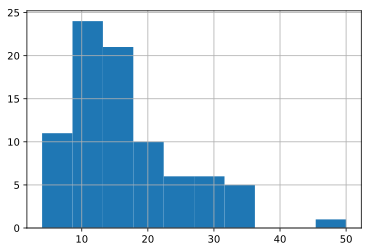

In [13]:
plt.grid()
plt.hist(survey['length'], bins=10)
plt.show()

### ノック 94 : 形態素解析で文書を解析してみよう

In [14]:
import MeCab
tagger = MeCab.Tagger()
text = 'すもももももももものうち'
words = tagger.parse(text)
words

'すもも\t名詞,一般,*,*,*,*,すもも,スモモ,スモモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nの\t助詞,連体化,*,*,*,*,の,ノ,ノ\nうち\t名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ\nEOS\n'

単語ごとに分割し、特定の品詞の単語のみを取得します。

In [15]:
words = tagger.parse(text).splitlines()
words_arr = []
for i in words:
  if i == 'EOS': 
    continue
  word_tmp = i.split()[0]
  words_arr.append(word_tmp)
words_arr

['すもも', 'も', 'もも', 'も', 'もも', 'の', 'うち']

### ノック 95 : 形態素解析で文章から「動詞・名詞」を抽出してみよう

In [16]:
text = 'すもももももももものうち'
words = tagger.parse(text).splitlines()
words_arr = []
parts = ['名詞', '動詞']

for i in words:
  if i == 'EOS' or i == '':
    continue
  
  word_tmp = i.split()[0]
  part = i.split()[1].split(',')[0]
  
  if not (part in parts): 
    continue
  words_arr.append(word_tmp)
words_arr

['すもも', 'もも', 'もも', 'うち']

### ノック 96 : 形態素解析で抽出した頻出する名詞を確認してみよう

In [17]:
all_words = []
parts = ['名詞']

for n in range(len(survey)):
  text = survey['comment'].iloc[n]
  words = tagger.parse(text).splitlines()
  
  words_arr = []
  
  for i in words:
    
    if i == 'EOS' or i == '':
      continue
    
    word_tmp = i.split()[0]
    part = i.split()[1].split(',')[0]
    
    if not (part in parts): 
      continue
    words_arr.append(word_tmp)
  
  all_words.extend(words_arr)
  
all_words[0:10]

['駅前', '若者', 'スポーツ', '場所', 'の', '子育て', '支援', '保育園', '駅前', '商店']

In [18]:
all_words_df = pd.DataFrame({'words': all_words, "count": len(all_words) * [1]})
all_words_df.head()

,count,words
0,1,駅前
1,1,若者
2,1,スポーツ
3,1,場所
4,1,の


In [19]:
all_words_df = all_words_df.groupby('words').sum()
all_words_df.head()

,count
words,
BBB,1
^^,1
おじさん,1
ごみ,1
そう,1


In [20]:
all_words_df.sort_values('count', ascending=False).head()

,count
words,
駅前,7
場所,6
街,6
の,5
公園,5


すべての単語に1を与え、groupbyで合計値を取ってソートします。

### ノック 97 : 関係のない単語を除去してみよう

ストップワードを設定します。関係の単語で除去すべき単語という意味です。

In [21]:
stop_words = ['の']

all_words = []
parts = ['名詞']

for n in range(len(survey)):
  text = survey['comment'].iloc[n]
  words = tagger.parse(text).splitlines()
  
  words_arr = []
  
  for i in words:
    if i == 'EOS' or i == '':
      continue
    word_tmp = i.split()[0]
    
    part = i.split()[1].split(",")[0]
    if not (part in parts):
      continue
    
    if word_tmp in stop_words:
      continue
    
    words_arr.append(word_tmp)
  
  all_words.extend(words_arr)

all_words[0:10]

['駅前', '若者', 'スポーツ', '場所', '子育て', '支援', '保育園', '駅前', '商店', '街']

In [22]:
all_words_df = pd.DataFrame({'words': all_words, "count": len(all_words) * [1]})
all_words_df = all_words_df.groupby('words').sum()
# print(all_words_df)
all_words_df.sort_values('count', ascending=False).head()

,count
words,
駅前,7
場所,6
街,6
公園,5
商店,5


「の」が削除され、「公園」が繰り上がっています。

### ノック 98 : 顧客満足度と頻出単語の関係を見てみよう

In [23]:
stop_words = ['の']

all_words = []
satisfaction = []

parts = ['名詞']

for n in range(len(survey)):
  text = survey['comment'].iloc[n]
  words = tagger.parse(text).splitlines()
  
  words_arr = []
  
  for i in words:
    if i == 'EOS' or i == '':
      continue
    word_tmp = i.split()[0]
    
    part = i.split()[1].split(",")[0]
    if not (part in parts):
      continue
    
    if word_tmp in stop_words:
      continue
    
    words_arr.append(word_tmp)
    satisfaction.append(survey['satisfaction'].iloc[n])
  all_words.extend(words_arr)

all_words_df = pd.DataFrame({"words": all_words, "satisfaction": satisfaction, "count": len(all_words) * [1]}) 
  
all_words_df.head()

,count,satisfaction,words
0,1,1,駅前
1,1,1,若者
2,1,5,スポーツ
3,1,5,場所
4,1,5,子育て


In [24]:
words_satisfaction = all_words_df.groupby('words').mean()['satisfaction']
words_count = all_words_df.groupby('words').sum()['count']

words_df = pd.concat([words_satisfaction, words_count], axis=1)
words_df.head()

,satisfaction,count
words,,
BBB,2.0,1
^^,5.0,1
おじさん,1.0,1
ごみ,2.0,1
そう,1.0,1


In [25]:
words_df = words_df.loc[words_df['count'] >= 3]
words_df.sort_values('satisfaction', ascending=False).head()

,satisfaction,count
words,,
子育て,4.333333,3
綺麗,4.333333,3
安心,4.333333,3
スポーツ,3.666667,3
道,3.000000,3


In [26]:
words_df.sort_values('satisfaction').head()

,satisfaction,count
words,,
駐車,1.000000,4
場,1.000000,4
信号,1.333333,3
大変,1.333333,3
駅前,1.428571,7


### ノック 99 : アンケート毎の特徴を表現してみよう
類似した文章の検索になります。

In [27]:
parts = ['名詞']
all_words_df = pd.DataFrame()
satisfaction = []

for n in range(len(survey)):
  text = survey['comment'].iloc[n]
  words = tagger.parse(text).splitlines()
  words_df = pd.DataFrame()
  
  for i in words:
    if i == 'EOS' or i == '':
      continue
    word_tmp = i.split()[0]
    
    part = i.split()[1].split(",")[0]
    if not (part in parts):
      continue
    
    if word_tmp in stop_words:
      continue
    
    words_df[word_tmp] = [1]
  
  all_words_df = pd.concat([all_words_df, words_df], ignore_index=True, sort=False)
all_words_df.head()

,駅前,若者,スポーツ,場所,子育て,支援,保育園,商店,街,生活,...,マスコット,夜間,不安,高齢,サポート,校庭,芝生,投稿,遊び,道具
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


fillnaでNaN部分を0に補完します。

In [28]:
all_words_df = all_words_df.fillna(0)
all_words_df.head()

,駅前,若者,スポーツ,場所,子育て,支援,保育園,商店,街,生活,...,マスコット,夜間,不安,高齢,サポート,校庭,芝生,投稿,遊び,道具
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ノック 100 : 類似アンケートを探してみよう

cos類似度を使ってターゲットと似たような文章を検索します。

In [29]:
print(survey['comment'].iloc[2])

子育て支援が嬉しい


In [30]:
target_text = all_words_df.iloc[2]
target_text.head()

駅前      0.0
若者      0.0
スポーツ    0.0
場所      0.0
子育て     1.0
Name: 2, dtype: float64

コサイン類似度で文章の類似度を定量化します。

In [31]:
cos_sim = []
for i in range(len(all_words_df)):
  cos_text = all_words_df.iloc[i]
  cos = np.dot(target_text, cos_text) / (np.linalg.norm(target_text) * np.linalg.norm(cos_text))
  
  cos_sim.append(cos)

all_words_df['cos_sim'] = cos_sim
all_words_df.sort_values('cos_sim', ascending=False).head()
  

,駅前,若者,スポーツ,場所,子育て,支援,保育園,商店,街,生活,...,夜間,不安,高齢,サポート,校庭,芝生,投稿,遊び,道具,cos_sim
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107
15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107
33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408248


上位のコメント表示してみます。上記を見ると、25,15,33,50となっています。

In [32]:
print(survey['comment'].iloc[2])
print(survey['comment'].iloc[24])
print(survey['comment'].iloc[15])
print(survey['comment'].iloc[33])

子育て支援が嬉しい
子育てがしやすい
子育てしやすい
働くママの支援をもっと増やして欲しい


## 関連記事
- [第1章 ウェブからの注文数を分析する10本ノック](/ml/data100/01/)
- [第2章 小売店のデータでデータ加工を行う10本ノック](/ml/data100/02/)
- [第3章 顧客の全体像を把握する10本ノック](/ml/data100/03/)
- [第4章 顧客の行動を予測する10本ノック](/ml/data100/04/)
- [第5章 顧客の退会を予測する10本ノック](/ml/data100/05/)
- [第6章 物流の最適ルートをコンサルティングする10本ノック](/ml/data100/06/)
- [第7章 ロジスティクスネットワークの最適設計を行う10本ノック](/ml/data100/07/)
- [第8章 数値シミュレーションで消費者行動を予測する10本ノック](/ml/data100/08/)
- [第9章 潜在顧客を把握するための画像認識10本ノック](/ml/data100/09/)
- [第10章 アンケート分析を行うための自然言語処理10本ノック](/ml/data100/10/)